<a href="https://colab.research.google.com/github/julidoominguez/SeriesdeTiempoAustral/blob/main/Sarima_X_facturacipon_vitalcer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Preparamos el entorno

In [ ]:
!pip install gspread
!pip install gspread-dataframe
!pip install --upgrade gspread
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 785.4 kB/s eta 0:00:00
  Attempting uninstall: gspread
    Found existing installation: gspread 6.0.2
    Uninstalling gspread-6.0.2:
      Successfully uninstalled gspread-6.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.1 MB/s eta 0:00:00


In [ ]:
# manipulación de data frames y EDA
import pandas as pd
import numpy as np
from datetime import timedelta                                 # diferencia de dos fechas

# visualización
import matplotlib.pyplot as plt
import seaborn as sns

# paquetes estadísticos - modelado de series temporales
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import statsmodels.api as sm                                   # modelos estadísticos
# !pip install pmdarima
import pmdarima as pm                                          # modelado automático SARIMA
from statsmodels.tsa.arima_model import ARIMA                  # modelo ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX         # modelo SARIMAX
from pylab import rcParams                                     # descomposicion de series temporales
from statsmodels.tsa.stattools import adfuller, kpss           # test Dickey-Fuller y KPSS
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf  # plot the (P)ACF

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Importamos y preparamos las series

In [ ]:
# URL de la hoja de Google Sheets
sheet_url = "https://docs.google.com/spreadsheets/d/1FSIizX5kpfBN14TNLekfFVNDO0dHJospR8aM0CNkQlg/edit?usp=sharing"

# Convertir la URL a un formato que pandas pueda leer
csv_url = sheet_url.replace('/edit?usp=sharing', '/export?format=csv')

# Leer los datos en un DataFrame de pandas
df_ventas_vitalcer = pd.read_csv(csv_url)

In [ ]:
# URL de la hoja de Google Sheets
sheet_url = "https://docs.google.com/spreadsheets/d/1y9nkBOyfktgLYkoJIBpenGepizO-x6tHnK36KWNLmos/edit?usp=sharing"

# Convertir la URL a un formato que pandas pueda leer
csv_url = sheet_url.replace('/edit?usp=sharing', '/export?format=csv')

# Leer los datos en un DataFrame de pandas
df_filtrado = pd.read_csv(csv_url)


print(df_filtrado.head())

         date  dieta
0  2019-11-15     62
1  2019-11-16     60
2  2019-11-19     88
3  2019-11-20     73
4  2019-11-21     68


In [ ]:
# URL de la hoja de Google Sheets
sheet_url = "https://docs.google.com/spreadsheets/d/1GWw8yNesP9cVktBnWaudd_XCGURI9HPd7bQNrvzoVFE/edit?gid=1987789933"

# Convertir la URL a un formato que pandas pueda leer
csv_url = sheet_url.replace('/edit?gid=', '/export?format=csv&gid=')

# Leer los datos en un DataFrame de pandas
df_datos_clima_moron = pd.read_csv(csv_url)

print(df_datos_clima_moron.head())

   YEAR  DOY     FECHA  QV2M  RH2M  PRECTOTCORR  WS2M  T2M_MAX  T2M_MIN  \
0  2019  182  1/7/2019  4.15 77.62         0.00  3.04    12.30    -0.56   
1  2019  183  2/7/2019  4.76 73.00         0.00  4.06    14.77     3.75   
2  2019  184  3/7/2019  3.78 75.06         0.00  3.54    10.85     0.47   
3  2019  185  4/7/2019  3.66 75.38         0.00  3.65     9.83     0.64   
4  2019  186  5/7/2019  3.66 83.56         0.00  3.21     9.29    -0.81   

   ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN  ALLSKY_SFC_SW_DNI  \
0              11.98              11.90              27.50   
1               7.33              11.34               7.05   
2              11.65              11.70              24.42   
3              12.00              12.00              26.79   
4              11.76              11.91              24.80   

   ALLSKY_SFC_SW_DIFF  TOA_SW_DWN  ALLSKY_SFC_PAR_TOT  CLRSKY_SFC_PAR_TOT  \
0                1.78       16.00               58.35               59.01   
1                5.00 

In [ ]:
# Convertir la columna Monto a tipo numérico
df_ventas_vitalcer['Monto'] = df_ventas_vitalcer['Monto'].str.replace('$', '', regex=False)  # Eliminar símbolo de moneda
df_ventas_vitalcer['Monto'] = df_ventas_vitalcer['Monto'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)  # Reemplazar comas y puntos
df_ventas_vitalcer['Monto'] = df_ventas_vitalcer['Monto'].astype(float)  # Convertir a float

# Convertir la columna Fecha a tipo datetime
df_ventas_vitalcer['Fecha'] = pd.to_datetime(df_ventas_vitalcer['Fecha'], format='%d/%m/%Y')

In [ ]:
# Asegurarse de que la columna 'FECHA' esté en formato de fecha en el DataFrame de datos climáticos
df_datos_clima_moron['FECHA'] = pd.to_datetime(df_datos_clima_moron['FECHA'], dayfirst=True)

# Asegurarse de que la columna 'RH2M' sea numérica
df_datos_clima_moron['RH2M'] = pd.to_numeric(df_datos_clima_moron['RH2M'], errors='coerce')

# Filtrar el DataFrame de datos climáticos para que contenga solo las fechas presentes en el DataFrame de facturación
df_filtered_humedad = df_datos_clima_moron[df_datos_clima_moron['FECHA'].isin(df_ventas_vitalcer['Fecha'])][['FECHA', 'RH2M']]

# Mostrar los primeros y últimos registros del DataFrame filtrado
print(df_filtered_humedad.head())
print(df_filtered_humedad.tail())

         FECHA  RH2M
137 2019-11-15 66.94
138 2019-11-16 75.19
141 2019-11-19 73.75
142 2019-11-20 69.25
143 2019-11-21 75.31
          FECHA  RH2M
1818 2024-06-22 92.94
1820 2024-06-24 81.62
1821 2024-06-25 85.44
1822 2024-06-26 82.25
1823 2024-06-27 77.06


In [ ]:
df_filtered_humedad.shape

(1380, 2)

In [ ]:
df_filtrado.shape

(1380, 2)

In [ ]:
df_ventas_vitalcer.shape

(122759, 7)

In [ ]:
# Agrupar por la columna 'Fecha' y sumar los valores de la columna 'Monto'
df_ventas_agregadas = df_ventas_vitalcer.groupby('Fecha')['Monto'].sum().reset_index()

# Mostrar las primeras filas del DataFrame resultante para verificar
print(df_ventas_agregadas.head())

       Fecha    Monto
0 2019-11-15 26796.40
1 2019-11-16 20712.54
2 2019-11-19 27271.31
3 2019-11-20 14520.83
4 2019-11-21 17245.30


In [ ]:
# Buscamos datos de inflacion para deflactar la serie
import requests
import pandas as pd

url = "https://apis.datos.gob.ar/series/api/series/?ids=145.3_INGNACNAL_DICI_M_15&format=json"

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    # Extraer la parte de los datos que contiene las series temporales
    if 'data' in data:
        # Convertir los datos a DataFrame
        ipc = pd.DataFrame(data['data'], columns=['timestamp', 'value'])
        ipc['timestamp'] = pd.to_datetime(ipc['timestamp'])  # Convertir timestamp a formato datetime de pandas
        print("Número total de entradas:", ipc.shape[0])  # Muestra el total de filas
        print(ipc.head(10))  # Imprimir las primeras 10 filas para verificar
        print(ipc.tail(10))  # Imprimir las últimas 10 filas para verificar
    else:
        print("No se encontraron datos de series temporales.")
else:
    print("Error al obtener los datos. Código de estado:", response.status_code)

# Convertir timestamp a datetime si aún no está convertido
ipc['timestamp'] = pd.to_datetime(ipc['timestamp'])

# Calcular el cambio porcentual mensual
ipc['variacion_mes'] = ipc['value'].pct_change() * 100


Número total de entradas: 90
   timestamp  value
0 2016-12-01 100.00
1 2017-01-01 101.59
2 2017-02-01 103.69
3 2017-03-01 106.15
4 2017-04-01 108.97
5 2017-05-01 110.53
6 2017-06-01 111.85
7 2017-07-01 113.79
8 2017-08-01 115.38
9 2017-09-01 117.57
    timestamp   value
80 2023-08-01 2044.28
81 2023-09-01 2304.92
82 2023-10-01 2496.27
83 2023-11-01 2816.06
84 2023-12-01 3533.19
85 2024-01-01 4261.53
86 2024-02-01 4825.79
87 2024-03-01 5357.09
88 2024-04-01 5830.23
89 2024-05-01 6073.70


In [ ]:
# Crear un rango de fechas desde el inicio hasta el final del periodo de ventas
rango_fechas = pd.date_range(start=ipc['timestamp'].min(), end=df_ventas_vitalcer['Fecha'].max(), freq='D')

# Reindexar el DataFrame ipc para incluir todas las fechas en el rango, usando el valor más cercano (ffill)
ipc_diario = ipc.set_index('timestamp').reindex(rango_fechas).ffill().reset_index()
ipc_diario.columns = ['Fecha', 'value', 'variacion_mes']

# Verificar el DataFrame resultante
print(ipc_diario.head(20))
print(ipc_diario.tail(20))

        Fecha  value  variacion_mes
0  2016-12-01 100.00            NaN
1  2016-12-02 100.00            NaN
2  2016-12-03 100.00            NaN
3  2016-12-04 100.00            NaN
4  2016-12-05 100.00            NaN
5  2016-12-06 100.00            NaN
6  2016-12-07 100.00            NaN
7  2016-12-08 100.00            NaN
8  2016-12-09 100.00            NaN
9  2016-12-10 100.00            NaN
10 2016-12-11 100.00            NaN
11 2016-12-12 100.00            NaN
12 2016-12-13 100.00            NaN
13 2016-12-14 100.00            NaN
14 2016-12-15 100.00            NaN
15 2016-12-16 100.00            NaN
16 2016-12-17 100.00            NaN
17 2016-12-18 100.00            NaN
18 2016-12-19 100.00            NaN
19 2016-12-20 100.00            NaN
          Fecha   value  variacion_mes
2746 2024-06-08 6073.70           4.18
2747 2024-06-09 6073.70           4.18
2748 2024-06-10 6073.70           4.18
2749 2024-06-11 6073.70           4.18
2750 2024-06-12 6073.70           4.18
2751 2024-

In [ ]:
# Crear un nuevo DataFrame para los datos deflactados
df_ventas_deflactadas = df_ventas_agregadas.copy()

# Unir los datos de ventas con los datos del IPC diario interpolados
df_ventas_deflactadas = pd.merge(df_ventas_deflactadas, ipc_diario[['Fecha', 'value']], on='Fecha', how='left')
df_ventas_deflactadas.rename(columns={'value': 'ipc'}, inplace=True)

# Calcular el índice de precios relativo al último índice disponible (para deflactar)
ultimo_ipc = ipc['value'].iloc[-1]
df_ventas_deflactadas['ipc_relativo'] = df_ventas_deflactadas['ipc'] / ultimo_ipc

# Deflactar el monto
df_ventas_deflactadas['Monto_deflactado'] = df_ventas_deflactadas['Monto'] / df_ventas_deflactadas['ipc_relativo']

# Mostrar las primeras filas del DataFrame resultante para verificar
print(df_ventas_deflactadas.head())

       Fecha    Monto    ipc  ipc_relativo  Monto_deflactado
0 2019-11-15 26796.40 273.22          0.04         595695.03
1 2019-11-16 20712.54 273.22          0.04         460448.31
2 2019-11-19 27271.31 273.22          0.04         606252.48
3 2019-11-20 14520.83 273.22          0.04         322804.04
4 2019-11-21 17245.30 273.22          0.04         383370.14


In [ ]:
df_ventas_deflactadas.shape

(1380, 5)

In [ ]:
df_ventas_deflactadas.head()

,Fecha,Monto,ipc,ipc_relativo,Monto_deflactado
0,2019-11-15,26796.40,273.22,0.04,595695.03
1,2019-11-16,20712.54,273.22,0.04,460448.31
2,2019-11-19,27271.31,273.22,0.04,606252.48
3,2019-11-20,14520.83,273.22,0.04,322804.04
4,2019-11-21,17245.30,273.22,0.04,383370.14


In [ ]:
df_filtered_humedad['FECHA'] = pd.to_datetime(df_filtered_humedad['FECHA'], format='%d/%m/%Y')

In [ ]:
df_ventas_deflactadas.to_csv('df_ventas_deflactadas.csv', index=False)

In [ ]:
df_filtered_humedad.to_csv('df_humendad.csv', index=False)

In [ ]:
df_filtrado.dtypes

date     object
dieta     int64
dtype: object

### Unimos los DF

In [ ]:
# URL de la hoja de Google Sheets
sheet_url = "https://docs.google.com/spreadsheets/d/1jLduPF2m4d7S9i0AW-bRKl26EpIwS-WywBWdDoVFeh8/edit?usp=sharing"

# Convertir la URL a un formato que pandas pueda leer
csv_url = sheet_url.replace('/edit?usp=sharing', '/export?format=csv')

# Leer los datos en un DataFrame de pandas
df_ventas_deflactadas = pd.read_csv(csv_url)

In [ ]:
# URL de la hoja de Google Sheets
sheet_url = "https://docs.google.com/spreadsheets/d/1cAUxRW-UFl3ie-C_OyEzhaLex75alNoTRZ3Dse9eCv8/edit?usp=sharing"

# Convertir la URL a un formato que pandas pueda leer
csv_url = sheet_url.replace('/edit?usp=sharing', '/export?format=csv')

# Leer los datos en un DataFrame de pandas
df_filtered_humedad = pd.read_csv(csv_url)

In [ ]:
# URL de la hoja de Google Sheets
sheet_url = "https://docs.google.com/spreadsheets/d/1y9nkBOyfktgLYkoJIBpenGepizO-x6tHnK36KWNLmos/edit?usp=sharing"

# Convertir la URL a un formato que pandas pueda leer
csv_url = sheet_url.replace('/edit?usp=sharing', '/export?format=csv')

# Leer los datos en un DataFrame de pandas
df_filtrado = pd.read_csv(csv_url)

In [ ]:
# Renombrar las columnas de fecha para que tengan el mismo nombre temporalmente
df_ventas_deflactadas.rename(columns={'Fecha': 'fecha'}, inplace=True)
df_filtrado.rename(columns={'date': 'fecha'}, inplace=True)
df_filtered_humedad.rename(columns={'FECHA': 'fecha'}, inplace=True)

In [ ]:
import pandas as pd

# Mostrar el tipo de dato de la columna 'date' antes de la conversión
print("Antes de la conversión:", df_filtrado['fecha'].dtype)

# Mostrar las primeras filas antes de la conversión para ver el formato de las fechas
print("Antes de la conversión, primeras filas:\n", df_filtrado['fecha'].head())

# Intentar inferir el formato de las fechas automáticamente
try:
    # Convertir la columna 'date' a formato datetime sin especificar formato
    df_filtrado['fecha'] = pd.to_datetime(df_filtrado['fecha'], errors='raise')
except Exception as e:
    print(f"Error al convertir la columna 'fecha': {e}")

# Si aún hay valores nulos, es posible que necesites un formato específico
if df_filtrado['fecha'].isnull().sum() > 0:
    # Especificar un formato conocido de las fechas si es posible
    # Ejemplo: para el formato 'dd-mm-yyyy'
    try:
        df_filtrado['fecha'] = pd.to_datetime(df_filtrado['fecha'], format='%d-%m-%Y', errors='coerce')
    except Exception as e:
        print(f"Error al convertir la columna 'date' con formato especificado: {e}")

# Mostrar las primeras filas del DataFrame para verificar las conversiones
print("Después de la conversión y renombrado, primeras filas:\n", df_filtrado.head())

# Mostrar el tipo de dato de la columna 'fecha' después de la conversión
print("Después de la conversión:", df_filtrado['fecha'].dtype)

# Verificar si hay valores nulos después de la conversión
print("Valores nulos en la columna 'fecha':", df_filtrado['fecha'].isnull().sum())


Antes de la conversión: object
Antes de la conversión, primeras filas:
 0    2019-11-15
1    2019-11-16
2    2019-11-19
3    2019-11-20
4    2019-11-21
Name: fecha, dtype: object
Después de la conversión y renombrado, primeras filas:
        fecha  dieta
0 2019-11-15     62
1 2019-11-16     60
2 2019-11-19     88
3 2019-11-20     73
4 2019-11-21     68
Después de la conversión: datetime64[ns]
Valores nulos en la columna 'fecha': 0


In [ ]:
import pandas as pd

# Mostrar el tipo de dato de la columna 'date' antes de la conversión
print("Antes de la conversión:", df_filtered_humedad['fecha'].dtype)

# Mostrar las primeras filas antes de la conversión para ver el formato de las fechas
print("Antes de la conversión, primeras filas:\n", df_filtered_humedad['fecha'].head())

# Intentar inferir el formato de las fechas automáticamente
try:
    # Convertir la columna 'date' a formato datetime sin especificar formato
    df_filtered_humedad['fecha'] = pd.to_datetime(df_filtered_humedad['fecha'], errors='raise')
except Exception as e:
    print(f"Error al convertir la columna 'fecha': {e}")

# Si aún hay valores nulos, es posible que necesites un formato específico
if df_filtered_humedad['fecha'].isnull().sum() > 0:
    # Especificar un formato conocido de las fechas si es posible
    # Ejemplo: para el formato 'dd-mm-yyyy'
    try:
        df_filtered_humedad['fecha'] = pd.to_datetime(df_filtered_humedad['fecha'], format='%d-%m-%Y', errors='coerce')
    except Exception as e:
        print(f"Error al convertir la columna 'date' con formato especificado: {e}")

# Mostrar las primeras filas del DataFrame para verificar las conversiones
print("Después de la conversión y renombrado, primeras filas:\n", df_filtered_humedad.head())

# Mostrar el tipo de dato de la columna 'fecha' después de la conversión
print("Después de la conversión:", df_filtered_humedad['fecha'].dtype)

# Verificar si hay valores nulos después de la conversión
print("Valores nulos en la columna 'fecha':", df_filtered_humedad['fecha'].isnull().sum())

Antes de la conversión: object
Antes de la conversión, primeras filas:
 0    2019-11-15
1    2019-11-16
2    2019-11-19
3    2019-11-20
4    2019-11-21
Name: fecha, dtype: object
Después de la conversión y renombrado, primeras filas:
        fecha  RH2M
0 2019-11-15 66.94
1 2019-11-16 75.19
2 2019-11-19 73.75
3 2019-11-20 69.25
4 2019-11-21 75.31
Después de la conversión: datetime64[ns]
Valores nulos en la columna 'fecha': 0


In [ ]:
import pandas as pd

# Mostrar el tipo de dato de la columna 'date' antes de la conversión
print("Antes de la conversión:", df_ventas_deflactadas['fecha'].dtype)

# Mostrar las primeras filas antes de la conversión para ver el formato de las fechas
print("Antes de la conversión, primeras filas:\n", df_ventas_deflactadas['fecha'].head())

# Intentar inferir el formato de las fechas automáticamente
try:
    # Convertir la columna 'date' a formato datetime sin especificar formato
    df_ventas_deflactadas['fecha'] = pd.to_datetime(df_ventas_deflactadas['fecha'], errors='raise')
except Exception as e:
    print(f"Error al convertir la columna 'fecha': {e}")

# Si aún hay valores nulos, es posible que necesites un formato específico
if df_ventas_deflactadas['fecha'].isnull().sum() > 0:
    # Especificar un formato conocido de las fechas si es posible
    # Ejemplo: para el formato 'dd-mm-yyyy'
    try:
        df_ventas_deflactadas['fecha'] = pd.to_datetime(df_ventas_deflactadas['fecha'], format='%d-%m-%Y', errors='coerce')
    except Exception as e:
        print(f"Error al convertir la columna 'date' con formato especificado: {e}")

# Mostrar las primeras filas del DataFrame para verificar las conversiones
print("Después de la conversión y renombrado, primeras filas:\n", df_ventas_deflactadas.head())

# Mostrar el tipo de dato de la columna 'fecha' después de la conversión
print("Después de la conversión:", df_ventas_deflactadas['fecha'].dtype)

# Verificar si hay valores nulos después de la conversión
print("Valores nulos en la columna 'fecha':", df_ventas_deflactadas['fecha'].isnull().sum())

Antes de la conversión: object
Antes de la conversión, primeras filas:
 0    2019-11-15
1    2019-11-16
2    2019-11-19
3    2019-11-20
4    2019-11-21
Name: fecha, dtype: object
Después de la conversión y renombrado, primeras filas:
        fecha    Monto    ipc  ipc_relativo  Monto_deflactado
0 2019-11-15 26796.40 273.22          0.04         595695.03
1 2019-11-16 20712.54 273.22          0.04         460448.31
2 2019-11-19 27271.31 273.22          0.04         606252.48
3 2019-11-20 14520.83 273.22          0.04         322804.04
4 2019-11-21 17245.30 273.22          0.04         383370.14
Después de la conversión: datetime64[ns]
Valores nulos en la columna 'fecha': 0


In [ ]:
# Merge los DataFrames en la columna 'fecha'
merged_df = pd.merge(df_ventas_deflactadas, df_filtrado, on='fecha')

merged_df = pd.merge(merged_df, df_filtered_humedad, on='fecha')

In [ ]:
merged_df.shape

(1380, 7)

In [ ]:
display(merged_df)

,fecha,Monto,ipc,ipc_relativo,Monto_deflactado,dieta,RH2M
0,2019-11-15,26796.40,273.22,0.04,595695.03,62,66.94
1,2019-11-16,20712.54,273.22,0.04,460448.31,60,75.19
2,2019-11-19,27271.31,273.22,0.04,606252.48,88,73.75
3,2019-11-20,14520.83,273.22,0.04,322804.04,73,69.25
4,2019-11-21,17245.30,273.22,0.04,383370.14,68,75.31
...,...,...,...,...,...,...,...
1375,2024-06-22,707310.00,6073.70,1.00,707310.00,79,92.94
1376,2024-06-24,758690.00,6073.70,1.00,758690.00,64,81.62
1377,2024-06-25,614865.00,6073.70,1.00,614865.00,64,85.44
1378,2024-06-26,765132.00,6073.70,1.00,765132.00,66,82.25


### Modelo SARIMA X

SARIMA facturación

In [ ]:
################ OTRA MANERA, A VECES AUTO ARIMA NO FUNCIONA BIEN. MEJOR USAR ESTO (JULI)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.special import inv_boxcox
from scipy.stats import boxcox

# Ordenar el DataFrame por fecha
merged_df = merged_df.sort_values('fecha', ascending=True)

# Separar el dataset en entrenamiento (80%) y prueba (20%)
train_size = int(len(merged_df) * 0.8)
train, test = merged_df.iloc[:train_size], merged_df.iloc[train_size:]

# Aplicar la transformación de Box-Cox a la variable objetivo
train['Monto_deflactado_boxcox'], lam = boxcox(train['Monto_deflactado'])

# Ajustar el modelo SARIMAX con las variables exógenas
sarimax_model = SARIMAX(train['Monto_deflactado_boxcox'],
                        # exog=train[['dieta', 'RH2M']],
                        order=(0, 1, 2),
                        seasonal_order=(1, 0, 0, 6))

sarimax_result_2 = sarimax_model.fit(disp=False)
print(sarimax_result_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:            Monto_deflactado_boxcox   No. Observations:                 1104
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 6)   Log Likelihood              -11609.691
Date:                            Tue, 09 Jul 2024   AIC                          23227.382
Time:                                    04:21:43   BIC                          23247.405
Sample:                                         0   HQIC                         23234.956
                                           - 1104                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8654      0.028    -31.057      0.000      -0.920      -0.811
ma.L2         -0.0676      0.028   

SARIMA X con Humedad y Búsquedas

In [ ]:
################ OTRA MANERA, A VECES AUTO ARIMA NO FUNCIONA BIEN. MEJOR USAR ESTO (JULI)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.special import inv_boxcox
from scipy.stats import boxcox

# Ordenar el DataFrame por fecha
merged_df = merged_df.sort_values('fecha', ascending=True)

# Separar el dataset en entrenamiento (80%) y prueba (20%)
train_size = int(len(merged_df) * 0.8)
train, test = merged_df.iloc[:train_size], merged_df.iloc[train_size:]

# Aplicar la transformación de Box-Cox a la variable objetivo
train['Monto_deflactado_boxcox'], lam = boxcox(train['Monto_deflactado'])

# Ajustar el modelo SARIMAX con las variables exógenas
sarimax_model = SARIMAX(train['Monto_deflactado_boxcox'],
                        exog=train[['dieta', 'RH2M']],
                        order=(0, 1, 2),
                        seasonal_order=(1, 0, 0, 6))

sarimax_result_2 = sarimax_model.fit(disp=False)
print(sarimax_result_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:            Monto_deflactado_boxcox   No. Observations:                 1104
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 6)   Log Likelihood              -11603.977
Date:                            Tue, 09 Jul 2024   AIC                          23219.955
Time:                                    16:30:03   BIC                          23249.989
Sample:                                         0   HQIC                         23231.315
                                           - 1104                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dieta        -86.0767     28.642     -3.005      0.003    -142.215     -29.939
RH2M         -46.3717     27.648   

El modelo SARIMA con variables exógenas tiene un Log Likelihood ligeramente mejor (-11603.976 vs. -11609.691). El AIC y el BIC del modelo con variables exógenas son ligeramente más bajos (23219.953 y 23249.987, respectivamente), lo que indica un mejor ajuste. Las variables exógenas (dieta y RH2M) muestran significancia en el modelo, especialmente la variable dieta (p = 0.003). Ambas versiones del modelo tienen valores similares en las estadísticas de Ljung-Box, Jarque-Bera y Heteroskedasticity, aunque el modelo con variables exógenas muestra una ligera mejora en la heterocedasticidad y curtosis. En conclusión, el modelo SARIMA con variables exógenas presenta un mejor ajuste a los datos y mejora en algunas estadísticas clave, sugiriendo que incluir estas variables puede mejorar la capacidad predictiva del modelo.

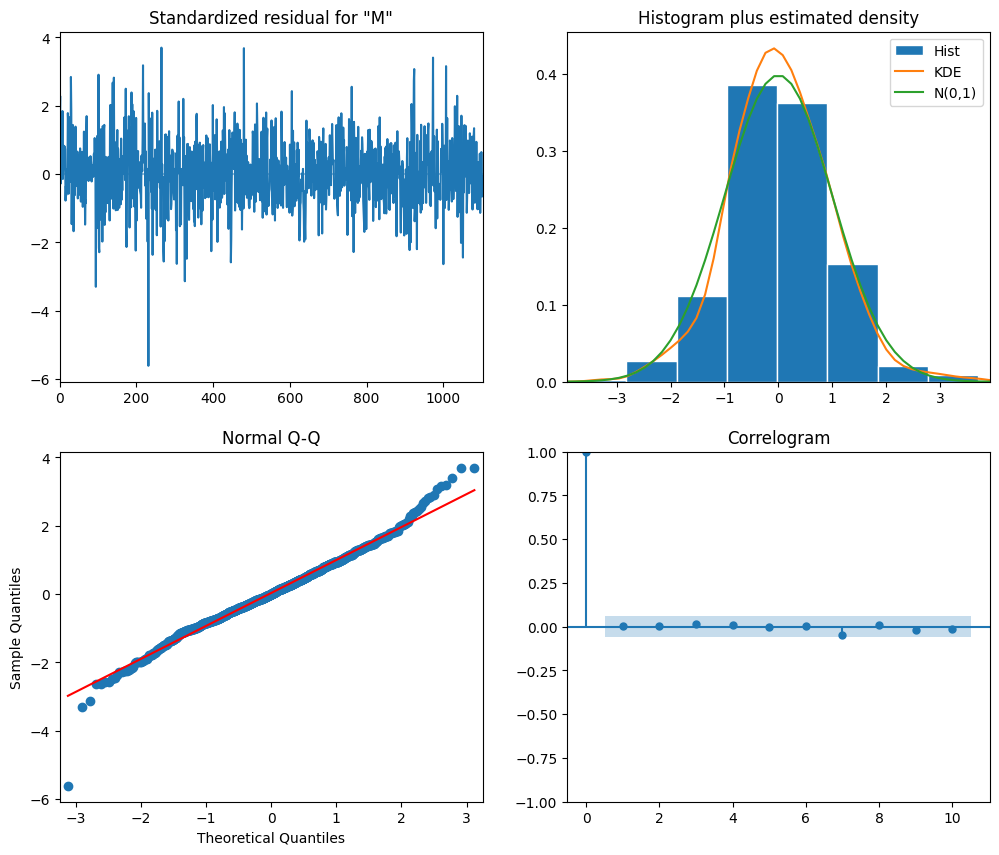

In [ ]:
fig_res_3 = sarimax_result_2.plot_diagnostics(figsize=(12,10))

RMSE: 183462.8375461266
MAE: 147316.63961163652


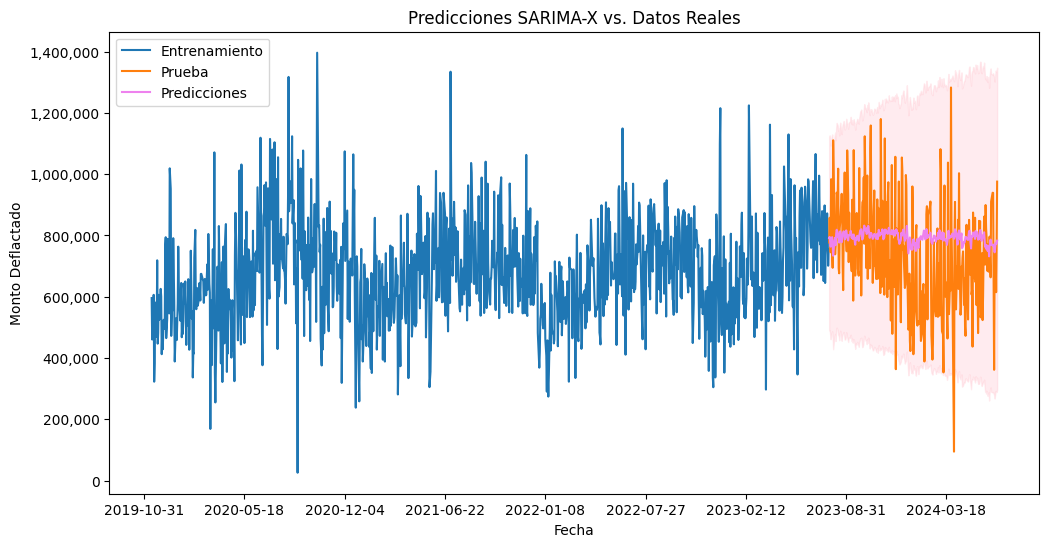

In [ ]:
# Realizar la predicción en el conjunto de prueba con intervalo de confianza
exog_test = test[['dieta', 'RH2M']]  # Variables exógenas para el conjunto de prueba
predictions_boxcox = sarimax_result_2.get_forecast(steps=len(test), exog=exog_test)
predictions_boxcox_values = predictions_boxcox.predicted_mean
conf_int = predictions_boxcox.conf_int()

# Invertir la transformación de Box-Cox
predictions_boxcox_inverse = inv_boxcox(predictions_boxcox_values, lam)
conf_int_lower = inv_boxcox(conf_int.iloc[:, 0], lam)
conf_int_upper = inv_boxcox(conf_int.iloc[:, 1], lam)

# Calcular las métricas de performance
rmse = np.sqrt(mean_squared_error(test['Monto_deflactado'], predictions_boxcox_inverse))
mae = mean_absolute_error(test['Monto_deflactado'], predictions_boxcox_inverse)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(train['fecha'], train['Monto_deflactado'], label='Entrenamiento')
plt.plot(test['fecha'], test['Monto_deflactado'], label='Prueba')
plt.plot(test['fecha'], predictions_boxcox_inverse, label='Predicciones', color='violet')
plt.fill_between(test['fecha'], conf_int_lower, conf_int_upper, color='pink', alpha=0.3)

import matplotlib.ticker as ticker

# Formatear los ejes para evitar notación científica
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.xlabel('Fecha')
plt.ylabel('Monto Deflactado')
plt.title('Predicciones SARIMA-X vs. Datos Reales')
plt.legend()
plt.show()

Al comparar los modelos SARIMA y SARIMAX utilizando el error cuadrático medio (RMSE) y el error absoluto medio (MAE), se observa que SARIMAX tiene un mejor rendimiento. Los valores del modelo SARIMA eran de un RMSE de 184,831.99 y un MAE de 148,744.76, mientras que los valores del modelo SARIMAX son un RMSE de 183,462.84 y un MAE de 147,316.64. Dado que SARIMAX presenta valores más bajos en ambas métricas, podemos concluir que este modelo ofrece predicciones más precisas.

Con Rolling Forecast

RMSE: 162569.5664463352
MAE: 128928.10840418405


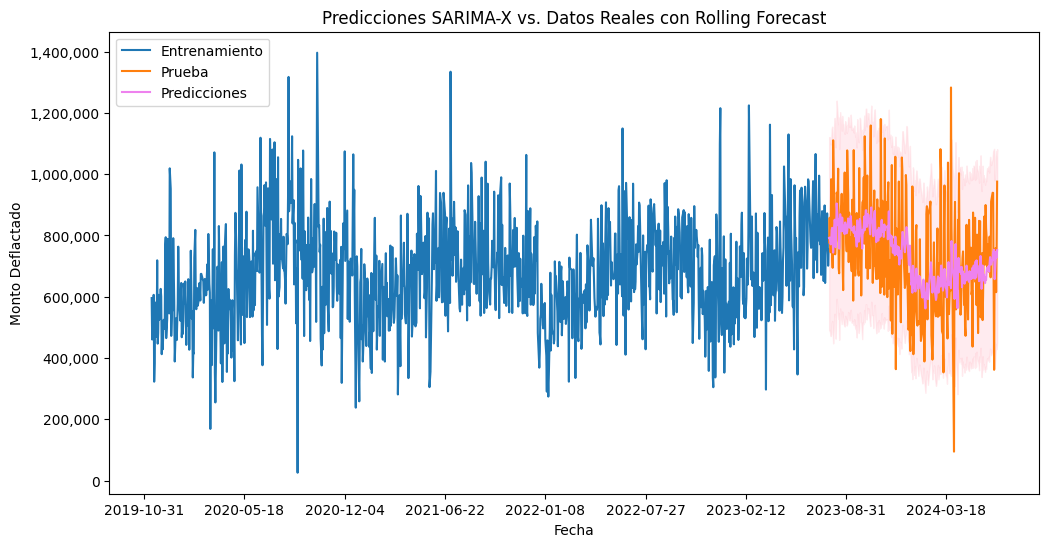

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.special import inv_boxcox
from scipy.stats import boxcox
import matplotlib.ticker as ticker

# Ordenar el DataFrame por fecha
merged_df = merged_df.sort_values('fecha', ascending=True)

# Separar el dataset en entrenamiento (80%) y prueba (20%)
train_size = int(len(merged_df) * 0.8)
train, test = merged_df.iloc[:train_size], merged_df.iloc[train_size:]

# Aplicar la transformación de Box-Cox a la variable objetivo
train['Monto_deflactado_boxcox'], lam = boxcox(train['Monto_deflactado'])
test['Monto_deflactado_boxcox'] = boxcox(test['Monto_deflactado'], lmbda=lam)

# Inicializar listas para almacenar predicciones y intervalos de confianza
predictions = []
conf_ints = []

# Rolling forecast
for i in range(len(test)):
    train_data = pd.concat([train, test.iloc[:i]])
    train_data_exog = train_data[['dieta', 'RH2M']]
    model = SARIMAX(train_data['Monto_deflactado_boxcox'],
                    exog=train_data_exog,
                    order=(0, 1, 2),
                    seasonal_order=(1, 0, 0, 6))
    result = model.fit(disp=False)

    # Predecir el siguiente valor
    exog_next = test[['dieta', 'RH2M']].iloc[i].values.reshape(1, -1)
    pred = result.get_forecast(steps=1, exog=exog_next)
    pred_mean = pred.predicted_mean
    conf_int = pred.conf_int()

    # Guardar las predicciones y intervalos de confianza
    predictions.append(pred_mean.values[0])
    conf_ints.append(conf_int.values[0])

# Convertir las predicciones y los intervalos de confianza con Box-Cox invertido
predictions_boxcox_inverse = inv_boxcox(np.array(predictions), lam)
conf_ints = np.array(conf_ints)
conf_int_lower = inv_boxcox(conf_ints[:, 0], lam)
conf_int_upper = inv_boxcox(conf_ints[:, 1], lam)

# Calcular las métricas de performance
rmse = np.sqrt(mean_squared_error(test['Monto_deflactado'], predictions_boxcox_inverse))
mae = mean_absolute_error(test['Monto_deflactado'], predictions_boxcox_inverse)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(train['fecha'], train['Monto_deflactado'], label='Entrenamiento')
plt.plot(test['fecha'], test['Monto_deflactado'], label='Prueba')
plt.plot(test['fecha'], predictions_boxcox_inverse, label='Predicciones', color='violet')
plt.fill_between(test['fecha'], conf_int_lower, conf_int_upper, color='pink', alpha=0.3)

# Formatear los ejes para evitar notación científica
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.xlabel('Fecha')
plt.ylabel('Monto Deflactado')
plt.title('Predicciones SARIMA-X vs. Datos Reales con Rolling Forecast')
plt.legend()
plt.show()


Al comparar los modelos SARIMA y SARIMAX utilizando el error cuadrático medio (RMSE) y el error absoluto medio (MAE), se observa que SARIMAX tiene un rendimiento ligeramente superior. Los valores del modelo SARIMA son un RMSE de 163,027.14 y un MAE de 128,221.77, mientras que los valores del modelo SARIMAX son un RMSE de 162,569.57 y un MAE de 128,928.11. Aunque el RMSE de SARIMAX es marginalmente más bajo, indicando una mejor precisión global, el MAE de SARIMA es ligeramente inferior, sugiriendo un mejor rendimiento en términos de errores absolutos promedio. En general, debido al menor RMSE, SARIMAX se puede considerar como un modelo ligeramente mejor en términos de precisión predictiva.


### Realizar la prueba HEGY


La prueba de hipótesis de HEGY (Hylleberg, Engle, Granger y Yoo) se utiliza para testear la presencia de raíces unitarias en series temporales que presentan estacionalidad. La prueba HEGY es especialmente útil para series con datos trimestrales o mensuales, ya que permite identificar no solo la existencia de una raíz unitaria en el nivel (no estacional) de la serie, sino también en las frecuencias estacionales.

Objetivos de la prueba HEGY:
Detectar raíces unitarias estacionales: La prueba permite identificar si las raíces unitarias están presentes en las frecuencias estacionales específicas. Por ejemplo, en una serie trimestral, puede detectar raíces unitarias en las frecuencias de 0, π/2, π, y 3π/2.

Distinguir entre raíces unitarias no estacionales y estacionales: Al aplicar la prueba HEGY, se puede determinar si una serie es estacionaria en niveles o si necesita diferencias adicionales para lograr la estacionariedad.



In [ ]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Función para transformar la serie temporal
def hegy_transformation(series):
    T = len(series)
    y_t = series
    y_t1 = y_t.shift(1)
    y_t2 = y_t.shift(2)
    y_t3 = y_t.shift(3)
    y_t4 = y_t.shift(4)
    dy_t1 = y_t.diff(1)
    dy_t2 = y_t.diff(2)
    dy_t3 = y_t.diff(3)
    dy_t4 = y_t.diff(4)
    dy_t4_lag1 = dy_t4.shift(1)

    transformed_df = pd.DataFrame({
        'y_t': y_t,
        'y_t1': y_t1,
        'y_t2': y_t2,
        'y_t3': y_t3,
        'y_t4': y_t4,
        'dy_t1': dy_t1,
        'dy_t2': dy_t2,
        'dy_t3': dy_t3,
        'dy_t4': dy_t4,
        'dy_t4_lag1': dy_t4_lag1
    }).dropna()

    return transformed_df

# Aplicar la prueba ADF a las componentes transformadas
def hegy_test(series):
    transformed_df = hegy_transformation(series)

    results = {}
    results['ADF_y_t'] = adfuller(transformed_df['y_t'])
    results['ADF_y_t1'] = adfuller(transformed_df['y_t1'])
    results['ADF_y_t2'] = adfuller(transformed_df['y_t2'])
    results['ADF_y_t3'] = adfuller(transformed_df['y_t3'])
    results['ADF_y_t4'] = adfuller(transformed_df['y_t4'])
    results['ADF_dy_t1'] = adfuller(transformed_df['dy_t1'])
    results['ADF_dy_t2'] = adfuller(transformed_df['dy_t2'])
    results['ADF_dy_t3'] = adfuller(transformed_df['dy_t3'])
    results['ADF_dy_t4'] = adfuller(transformed_df['dy_t4'])
    results['ADF_dy_t4_lag1'] = adfuller(transformed_df['dy_t4_lag1'])

    return results

# Aplicar la prueba HEGY a cada una de las series
hegy_results = {}
for column in ['dieta', 'RH2M', 'Monto_deflactado']:
    hegy_results[column] = hegy_test(merged_df[column])

hegy_results


{'dieta': {'ADF_y_t': (-4.868142872940628,
   4.021124801874516e-05,
   20,
   1354,
   {'1%': -3.4351888040389302,
    '5%': -2.8636769637158244,
    '10%': -2.5679077212657284},
   9469.558766459673),
  'ADF_y_t1': (-4.879847002600211,
   3.8165116347671255e-05,
   20,
   1354,
   {'1%': -3.4351888040389302,
    '5%': -2.8636769637158244,
    '10%': -2.5679077212657284},
   9468.516832525906),
  'ADF_y_t2': (-4.883157798097431,
   3.760472885634127e-05,
   20,
   1354,
   {'1%': -3.4351888040389302,
    '5%': -2.8636769637158244,
    '10%': -2.5679077212657284},
   9469.218205275769),
  'ADF_y_t3': (-4.885977677213466,
   3.713368202476324e-05,
   20,
   1354,
   {'1%': -3.4351888040389302,
    '5%': -2.8636769637158244,
    '10%': -2.5679077212657284},
   9469.564265709723),
  'ADF_y_t4': (-4.897931241155436,
   3.5199164655946856e-05,
   20,
   1354,
   {'1%': -3.4351888040389302,
    '5%': -2.8636769637158244,
    '10%': -2.5679077212657284},
   9469.516384413551),
  'ADF_dy_t1': 


La prueba de Hegy aplicada a las series 'dieta', 'RH2M' y 'Monto_deflactado' revela que todas presentan evidencia significativa de raíces unitarias con tendencias determinísticas, tanto en niveles como en primeras diferencias. Los valores del estadístico ADF para todas las variables y sus transformaciones temporales (y_t, dy_t) son más negativos que los valores críticos en los niveles del 1%, 5% y 10%, indicando rechazo de la hipótesis nula de no estacionariedad en la mayoría de los casos. Esto sugiere que las series son estacionarias tras la diferenciación